# LSTM for sentiment analysis

imports

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import spacy
import pandas as pd
from IPython.display import display
import cv2
import os
import torch.nn as nn
import torch.nn.functional as F

### OPTIONS

In [2]:
option_display = True

### SETTINGS

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data loading

In [4]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

train_data_path = '../../data/train'
test_data_path = '../../data/test'

IMG_SIZE = 512

trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

train_data = ImageFolder(train_data_path, transform=trans)
train_dataset, valid_dataset = random_split(train_data, lengths=[0.8,0.2])

test_dataset = ImageFolder(test_data_path, transform=trans)
test_dataset_fancy = ImageFolder(test_data_path, transform=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])
Pizza


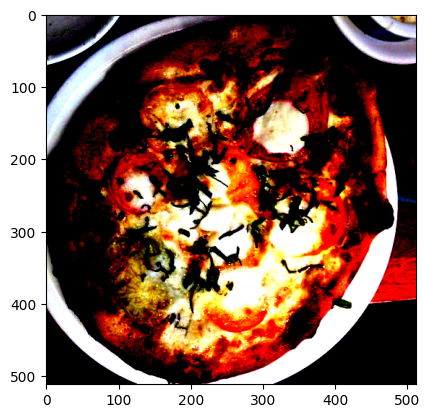

In [5]:
import matplotlib.pyplot as plt

class_lookup = {
    0: 'Not Pizza',
    1: 'Pizza'
}

if option_display:

    sample = train_dataset[10]

    plt.imshow(sample[0].transpose(0,2).transpose(0,1))
    print(sample[0].size())
    print(class_lookup[sample[1]])

## Model creation

In [6]:
from PizzaNet import PizzaNet

Using a pretrained nn for better results instead

In [7]:
from torchvision import datasets, models, transforms
import torch.nn as nn

model = models.resnet18(pretrained=True)

for params in model.parameters():
  params.requires_grad_ = False

nr_filters = model.fc.in_features
model.fc = nn.Linear(nr_filters, 1)

c:\Users\pierre\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pierre\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model = PizzaNet(IMG_SIZE)

In [9]:
model.to(device)

if option_display:
    print(model)

PizzaNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=230400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (soft): Softmax(dim=1)
)


training hyperparameters

In [10]:
EPOCHS = 10
BATCH_SIZE = 16
LR = 0.0001

epoch_print_interval = 5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

max_acc = None

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
import torchmetrics

def evaluate(model, dataloader):
    
    f1 = torchmetrics.F1Score(task='binary', average='macro')
    model.eval()
    total_size = 0

    predicted = []
    targets = []
    
    losses = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            
            labels = labels.type(torch.LongTensor)
            predicted_labels = model(inputs.to(device)).squeeze().to(device='cpu')
            
            losses.append(float(criterion(predicted_labels, labels).item()))
            
            predicted.append(predicted_labels)
            targets.append(labels)
            
            total_size += labels.size(0)

    predicted = torch.cat([*predicted])
    targets = torch.cat([*targets])

    accuracy = (predicted.argmax(1) == targets).sum().item()/total_size
    f1score = f1(predicted.argmax(1), targets)
    
    return accuracy, f1score, sum(losses)/len(losses)

training options

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(comment='PizzaNet')

In [14]:
for i in tqdm(range(1, EPOCHS+1)):
    
    model.train()

    for idx, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor).to(device)
        

        labels_pred = model(inputs).to(device)
        labels_pred = labels_pred.squeeze()
        #print(labels_pred)

        loss = criterion(labels_pred, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    train_acc, train_f1, train_loss = evaluate(model, train_loader)
    writer.add_scalar('Accuracy/train', train_acc, i)
    writer.add_scalar('F1-Score/train', train_f1, i)
    writer.add_scalar('Loss/train', train_loss, i)

    valid_acc, valid_f1, valid_loss = evaluate(model, valid_loader)
    writer.add_scalar('Accuracy/validation', valid_acc, i)
    writer.add_scalar('F1-Score/validation', valid_f1, i)
    writer.add_scalar('Loss/validation', valid_loss, i)

    if i % epoch_print_interval == 0:
        res_str = '{} accuracy: {} | f1-score: {} | loss: {}'
        print(f'epoch {i}:')
        print(res_str.format('train', train_acc, train_f1, train_loss))
        print(res_str.format('validation', valid_acc, valid_f1, valid_loss))
        print('-'*26)

writer.flush()
writer.close()

 50%|█████     | 5/10 [04:42<04:39, 55.93s/it]

epoch 5:
train accuracy: 0.73515625 | f1-score: 0.6737247109413147 | loss: 0.5562733773142099
validation accuracy: 0.675 | f1-score: 0.6060606241226196 | loss: 0.6229840353131294
--------------------------


100%|██████████| 10/10 [09:21<00:00, 56.16s/it]

epoch 10:
train accuracy: 0.9078125 | f1-score: 0.9034369587898254 | loss: 0.4103854760527611
validation accuracy: 0.684375 | f1-score: 0.6379928588867188 | loss: 0.6133977919816971
--------------------------


In [15]:
test_acc, test_f1, test_loss = evaluate(model, test_loader)
print('TEST accuracy: {} | f1-score: {} | loss: {}'.format(test_acc, test_f1, test_loss))

TEST accuracy: 0.6885245901639344 | f1-score: 0.6095890402793884 | loss: 0.6098676077697588


In [20]:
def inference():

    idx = torch.randint(1, len(test_dataset), (1,))

    input, label =  test_dataset[idx]

    plt.imshow(input[1])

    if model(input.to(device).unsqueeze(dim=0)).argmax(1) == 1:
        print('Pizza')
    else:
        print('Not Pizza')

Pizza


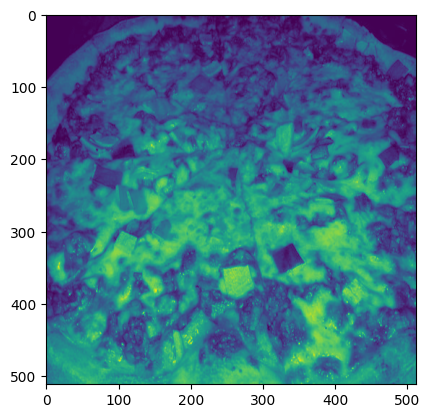

In [22]:
inference()

In [23]:
model_path = f'saves{os.sep}latest_model_pizzanet.pickle'
 
torch.save(model.state_dict(), model_path)

## results

In [ ]:
model_path_load = model_path

model = torch.load(model_path_load)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import random
rand_idx = random.randint(0,len(test_dataset)-1)

sample_img, sample_label = test_dataset[rand_idx]
sample_img_fancy, _ = test_dataset_fancy[rand_idx]

pred = torch.round(F.sigmoid(model(sample_img.to(device).unsqueeze(dim=0)).to('cpu')))

opencv_image = np.array(sample_img_fancy)[:, :, ::-1].copy() 

print(f'Real class: {class_lookup[sample_label]}')
print(f'Pred class: {class_lookup[pred.item()]}')

cv2.imshow('img', opencv_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Real class: Pizza
Pred class: Pizza
